# Reinforcement learning for robotics
This is the initial notebook that you will need to fill out through the semester. 
### Setup
First let's make sure that everything is working properly:

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
assert gym.__version__=='1.0.0',"You need a newer version of gym"
print("Everything seems good")

Everything seems good


### Outline
As teaching a robot how to walk is tricky, you will first test your algorithm on a much simpler task: Balancing an inverted pendulum.
This week, you will:
- Setup a first enviromnent
- Run a random policy
- Modify the distribution of this policy

In [2]:
#create the environment
envname="InvertedPendulum-v5"
env = gym.make_vec(envname,render_mode='rgb_array',vectorization_mode='sync')

This environment is called InvertedPendulum, and is running in the Mujoco simulator. You can check what it can do by reading the [documentation](https://gymnasium.farama.org/environments/mujoco/inverted_pendulum/)

Your first task is to find what are the state space and the action space. Additionally, answer the following questions:
- What is the dimension of the state space?
- What is the dimension of the action space?
- How could you get these dimentions directly in your code?
- When your ran these commands, you should have gotten an array of dimension 2. What does each of the dimension represent?

_Answers_: - What is the dimension of the state space? 4
- What is the dimension of the action space? 1   

In [ ]:
obs, info = env.reset()
print("State space dimension:", env.single_observation_space.shape)
print("Action space dimension:", env.single_action_space.shape)
print("Action space low:", env.single_action_space.low)
print("Action space high:", env.single_action_space.high)

state_dim = env.single_observation_space.shape[0]
action_dim = env.single_action_space.shape[0]
num_params = state_dim * action_dim

print("Number of parameters (linear model without bias):", num_params)

State space dimension: (4,)
Action space dimension: (1,)
Action space low: [-3.]
Action space high: [3.]
Number of parameters (linear model without bias): 4


### Visualization
Gymnasium is providing a visualisation function, let's try it

In [3]:
def render_notebook(env,id,title=""):
    clear_output(wait=True)
    plt.imshow(env.render()[id])
    plt.axis('off')
    plt.tight_layout()
    plt.title(title)
    plt.show()
    plt.pause(0.1)

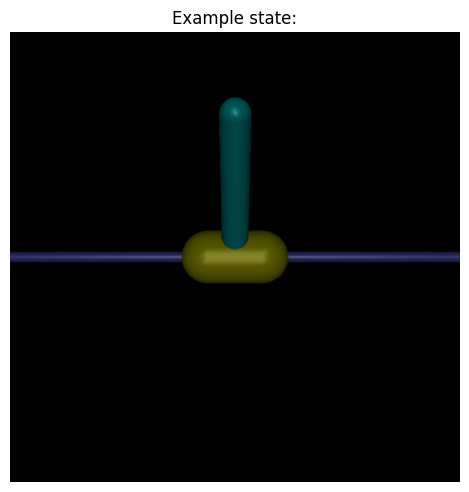

In [4]:
obs, info = env.reset()
render_notebook(env, 0, "Example state:")


Nice right?

### Random policy
Now you will try to implement a random policy: Uniformely chose a random action at each time step.

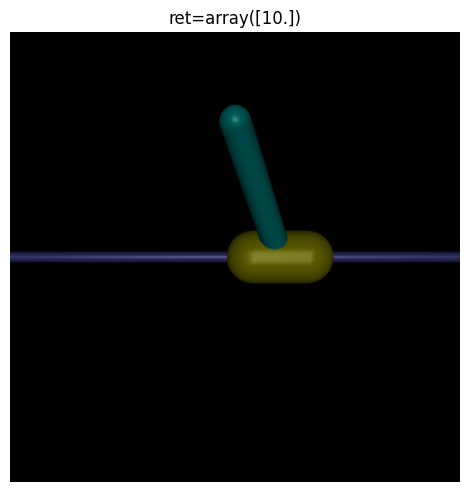

In [ ]:
terminated = [False]
env.reset()
ret=0
while not all(terminated):
    action = np.random.uniform(-3, 3, size= env.action_space.shape)
    _,reward, terminated,truncated,info = env.step(action)
    terminated = terminated|truncated
    ret+=reward
    render_notebook(env,0,f"{ret=}")

### Other distribution
This policy is quite terrible, so let's try to improve it by using a gaussian distribution instead. Test several standard deviations and see which one works best

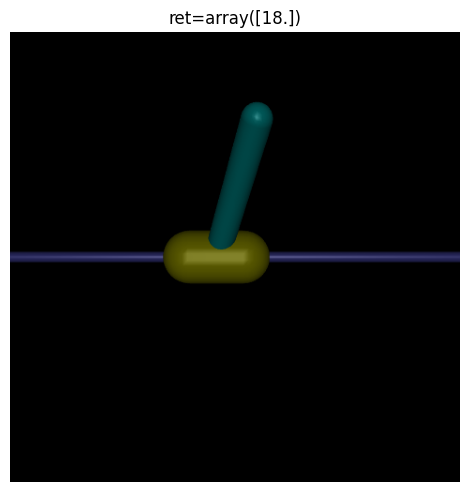

In [ ]:

terminated = [False]
std = 0.1
env.reset()
ret=0
while not all(terminated):
    action = np.random.normal(0, std, size=env.action_space.shape)
    _,reward, terminated,truncated,info = env.step(action)
    terminated = terminated|truncated
    ret+=reward
    render_notebook(env,0,f"{ret=}")

This concludes this first part of the project, next week we will try to implement a feedback controler in this system. 
In the meantime, feel free to get more confortable with the documentation of gymnasium

### Feedback Policy

FeedBack Policy u=-Kx avec K a determiner

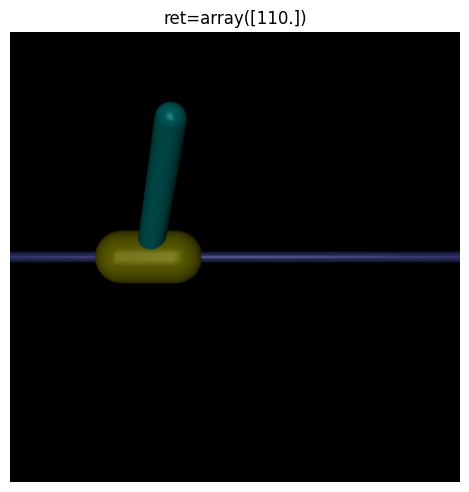

In [ ]:
K = np.array([[-1.0 , -2.0, -3.0, -4.0]]) 
terminated = [False]
env.reset()
ret=0
while not all(terminated):
    action = -np.dot(K, obs.T)
    obs,reward, terminated,truncated,info = env.step(action)
    terminated = terminated|truncated
    ret+=reward
    render_notebook(env,0,f"{ret=}")
    

In [ ]:
def simulate(K):
    obs, info = env.reset()
    terminated = [False]
    ret = 0
    while not all(terminated):
        action = -np.dot(K, obs[0])
        obs, reward, terminated, truncated, info = env.step([action])
        terminated = terminated | truncated
        ret += reward
    return ret

bret = -np.inf  
bK = None
num = 1000000
for i in range(num):
    K_cand = np.random.uniform(low=-5, high=5, size=(
                                                     env.action_space.shape[1],
                                                     env.single_observation_space.shape[0]))
    cret = simulate(K_cand)
    if cret > bret:
        bret = cret
        bK = K_cand 
    if np.isclose(cret.item(), 1000.0):
        print(f"Iteration {i}: reward = {cret}, best reward = {bret}")
        break
    print(f"Iteration {i}: reward = {cret}, best reward = {bret}")

print(f"Best K found : {bK}", f"best Reward = {bret}")


Iteration 0: reward = [5.], best reward = [5.]
Iteration 1: reward = [25.], best reward = [25.]
Iteration 2: reward = [12.], best reward = [25.]
Iteration 3: reward = [6.], best reward = [25.]
Iteration 4: reward = [5.], best reward = [25.]
Iteration 5: reward = [10.], best reward = [25.]
Iteration 6: reward = [5.], best reward = [25.]
Iteration 7: reward = [12.], best reward = [25.]
Iteration 8: reward = [4.], best reward = [25.]
Iteration 9: reward = [8.], best reward = [25.]
Iteration 10: reward = [5.], best reward = [25.]
Iteration 11: reward = [18.], best reward = [25.]
Iteration 12: reward = [27.], best reward = [27.]
Iteration 13: reward = [4.], best reward = [27.]
Iteration 14: reward = [8.], best reward = [27.]
Iteration 15: reward = [4.], best reward = [27.]
Iteration 16: reward = [31.], best reward = [31.]
Iteration 17: reward = [6.], best reward = [31.]
Iteration 18: reward = [4.], best reward = [31.]
Iteration 19: reward = [5.], best reward = [31.]
Iteration 20: reward = [

In [ ]:

obs[0].shape

(4,)

In [ ]:
K_cand.shape

(1, 4)

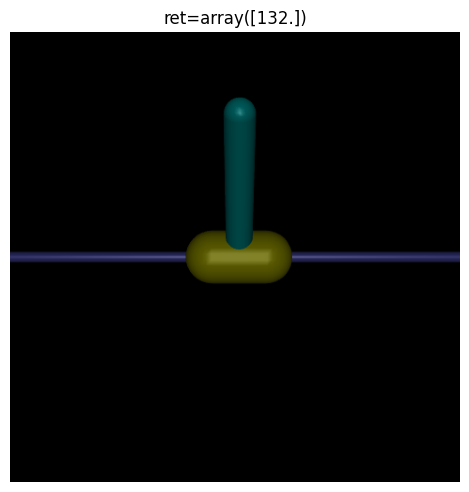

[[ 0.01464913 -0.00280301 -0.00552433  0.0093686 ]]


In [ ]:
obs, info = env.reset()
terminated = [False]
ret = 0

while not all(terminated):
    action = -np.dot(bK, obs.T)
    obs, reward, terminated, truncated, info = env.step(action)
    print(obs)
    terminated = terminated | truncated
    ret += reward
    render_notebook(env, 0, f"{ret=}")

### Reinforcement learning (RL) Week 3 (test) Flo

In [ ]:
#policy : a= -K s   => deterministic, linear, parameterized policy 
#grad compute with finite difference Not WORKING

def episode(K):
    obs, info = env.reset()
    terminated = [False]
    ret = 0.0
    while not all(terminated):
        action = -np.dot(K, obs[0])
        action = np.clip(action, -3.0, 3.0)
        obs, reward, terminated, truncated, info = env.step([action])
        terminated = terminated | truncated
        ret += float(reward[0]) 
        
    return ret


def compute_J(K, n_episodes=100):
    total = 0.0
    for i in range(n_episodes):
        total += episode(K)
    return total / n_episodes


def compute_gradJ(K, h=0.01):
    gradJ = np.zeros_like(K)
    for i in range(K.shape[0]):
        for j in range(K.shape[1]):
            K_plus = K.copy()
            K_minus = K.copy()

            K_plus[i, j]  += h
            K_minus[i, j] -= h

            r_plus  = compute_J(K_plus)
            r_minus = compute_J(K_minus)

            gradJ[i, j] = (r_plus - r_minus) / (2.0 * h)

    return gradJ


def training(a, iterations, h):
    K = np.random.uniform(low=-5, high=5, size=(env.action_space.shape[1],env.single_observation_space.shape[0]))
    #K = np.array([[-0.0, -4, -1, -2.3]]).reshape(env.action_space.shape[1],env.single_observation_space.shape[0])
    best_reward = -np.inf
    best_K = K.copy()
    iteration_reached = None
    target = 1000.0
    for i in range(iterations):
        gradJ = compute_gradJ(K, h=h)
        K = K + a * gradJ
        cret = compute_J(K)
        if cret > best_reward:
            best_reward = cret
            best_K = K.copy()
        print(f"Iteration {i}: reward = {cret:.2f}, best reward = {best_reward:.2f}")
        print(K)
        print(gradJ)
        if cret >= target:
            iteration_reached = i
            print(f">>> Cible de reward {target} atteinte à l'itération {i}.")
            break
    print(f"Best K found: {best_K}")
    print(f"Best reward: {best_reward:.2f}")

    return best_K, best_reward, iteration_reached


training(a=0.001, iterations=100000, h=0.00001)

In [ ]:
obs[0].shape


In [ ]:
K = np.random.uniform(low=-3, high=3, size=(env.action_space.shape[1],env.single_observation_space.shape[0]))
gamma = 0.99
alpha = 0.01 
sigma = 0.5
bret = -np.inf  # Initialize best reward to negative infinity
bK = None

def policy(s):
    return np.random.normal(np.dot(K,s),sigma)

def compute_log_gradient(s, a):
    mu = np.dot(K, s)
    return ((a - mu) * s / sigma**2) 

for episode in range(5000):
    obs, info = env.reset()
    terminated = [False]
    ret = 0.0
    obss,actions,rewards=[],[],[]
    while not all(terminated):
        s = obs[0]
        action = policy(s)
        action = np.clip(action, -3.0, 3.0)
        next_obs, reward, terminated, truncated, info = env.step([action])
        terminated = terminated | truncated
        obss.append(s)
        actions.append(action)  
        rewards.append(reward)
        ret += reward
        obs = next_obs

    if ret >= bret:
        bret = ret 
        bK = K.copy

    returns = np.zeros(len(rewards))
    G = 0
    for t in reversed(range(len(rewards))):
        G = rewards[t] + gamma * G
        returns[t] = G
    
    alpha = 0.0005 / (1 + 0.00005 * episode)
    
    for t in range(len(obss)):
        grad = compute_log_gradient(obss[t], actions[t])  # Gradient of log-probability
        K += alpha * grad * returns[t]  # Gradient ascent

    print(f"Episode {episode}, Total Reward: {ret}, Best Reward: {bret}, K:{K}" )



Action probabilities: [1.]
Sampled action: 0


TypeError: Unable to iterate over the following elements: 0

KeyboardInterrupt: 

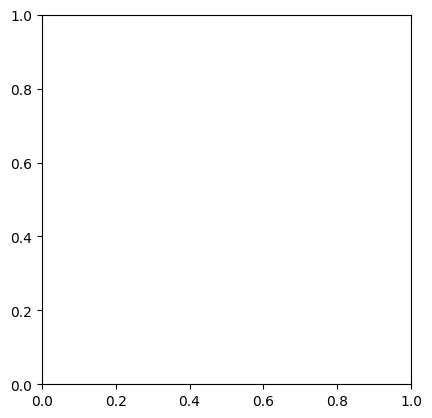

In [ ]:
obs, info = env.reset()
terminated = [False]
ret = 0

while not all(terminated):
    s = obs[0]  # (4,)
    action = np.dot(bK, s)  # => shape (1,)
    action = np.clip(action, -3, 3)
    
    obs, reward, terminated, truncated, info = env.step([action])
    terminated = terminated | truncated
    
    ret += reward
    render_notebook(env, 0, f"{ret=}")

### Reinforcement learning (RL) Week 3 (test) Selim

C:\Users\kello\AppData\Local\Temp\ipykernel_28220\2983246302.py:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  returns[t] = G


[[ 0.10370842 -0.05799796 -0.14558713  0.17225694]]
Episode 0, Total Reward: [17.], Best Reward: [17.]
[[ 0.09790312 -0.05671557 -0.12827264  0.14082019]]
Episode 1, Total Reward: [11.], Best Reward: [17.]
[[ 0.10461224 -0.06773789 -0.19452073  0.18947878]]
Episode 2, Total Reward: [19.], Best Reward: [19.]
[[ 0.11069985 -0.07374049 -0.30743466  0.3853659 ]]
Episode 3, Total Reward: [18.], Best Reward: [19.]
[[ 0.13051381 -0.10604576 -0.40681528  0.47744856]]
Episode 4, Total Reward: [15.], Best Reward: [19.]
[[ 0.14026935 -0.11441723 -0.27212958  0.23675287]]
Episode 5, Total Reward: [14.], Best Reward: [19.]
[[ 0.13590705 -0.10785819 -0.25519616  0.1769412 ]]
Episode 6, Total Reward: [16.], Best Reward: [19.]
[[ 0.13731095 -0.12298331 -0.26457973  0.14672102]]
Episode 7, Total Reward: [20.], Best Reward: [20.]
[[ 0.14229353 -0.12738504 -0.33728665  0.3136578 ]]
Episode 8, Total Reward: [15.], Best Reward: [20.]
[[ 0.1459749  -0.15384472 -0.30561709  0.19112492]]
Episode 9, Total Rewa

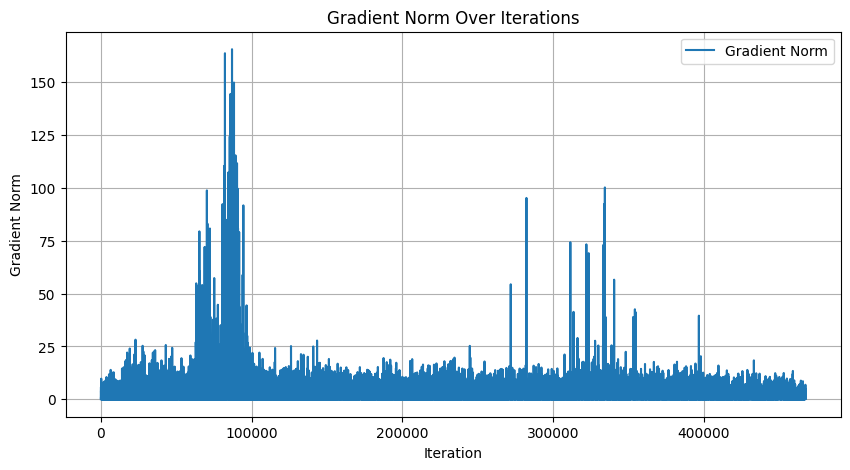

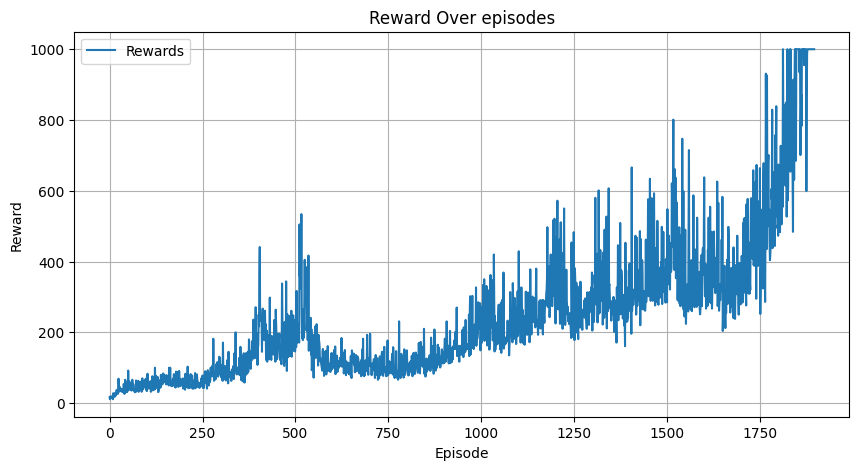

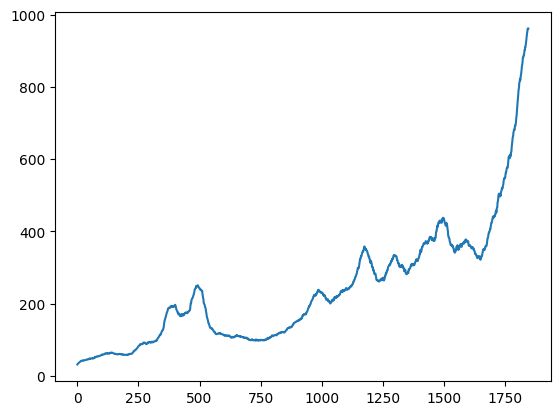

In [8]:
state_dim = env.observation_space.shape[1]
action_dim = env.action_space.shape[1]

# Initialize policy parameters
theta = np.random.randn(action_dim,state_dim)*0.1
best_reward = -np.inf
best_theta = None
action_std=0.25
num_episodes=5000
gamma=0.99
time = 0

def policy(state):
    mean = np.dot(theta,state)
    linear_action=np.random.normal(mean, action_std)
    action=np.tanh(linear_action)
    return action

def compute_log_gradient(state, action):
    linear_action = np.arctanh(np.clip(action, -1 +0.00001, 1 - 0.00001)) 
    mean = np.dot(theta, state)
    log_gradient = np.outer((linear_action - mean), state) / action_std**2
    return log_gradient

gradient_norms = []
reward_each_episode=[]
for episode in range(num_episodes):
    obs, info = env.reset()
    state = obs[0]
    trajectory = [] 
    total_reward = 0
    done = False
    while not done:
        action = policy(state)
        next_state, reward, done, truncated, _ = env.step([action])
        done = done or truncated
        trajectory.append((state, action, reward))  # Store in trajectory
        total_reward += reward
        state = next_state[0]

    # Track best performance
    if total_reward == best_reward:
        time += 1  
    else:
        time = 0  

    if time >= 20:  # Stop if no improvement for 20 episodes
        break
    
    if total_reward > best_reward:  # Update best_reward only if strictly better
        best_reward = total_reward
        best_theta = theta  

    returns = np.zeros(len(trajectory))
    G = 0
    for t in reversed(range(len(trajectory))):
        G = trajectory[t][2] + gamma * G 
        returns[t] = G
    
    alpha = 0.01/(1+0.1*episode) 
    for t, (state, action, _) in enumerate(trajectory):
        grad = compute_log_gradient(state, action)
        theta += alpha * grad * returns[t]
        
        grad_norm = 0
        grad_norm = np.linalg.norm(grad) 
        gradient_norms.append(grad_norm)  
    print(theta)     
    reward_each_episode.append(total_reward)
    print(f"Episode {episode}, Total Reward: {total_reward}, Best Reward: {best_reward}")


plt.figure(figsize=(10, 5))
plt.plot(gradient_norms, label="Gradient Norm")
plt.xlabel("Iteration")
plt.ylabel("Gradient Norm")
plt.title("Gradient Norm Over Iterations")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(reward_each_episode, label="Rewards")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Reward Over episodes")
plt.legend()
plt.grid()
plt.show()

window_size = 50
moving_avg = [np.mean(reward_each_episode[i-window_size:i]) for i in range(window_size, len(reward_each_episode))]
plt.plot(moving_avg, label="Moving Average")

theta = best_theta
np.save('trained_theta.npy', theta)

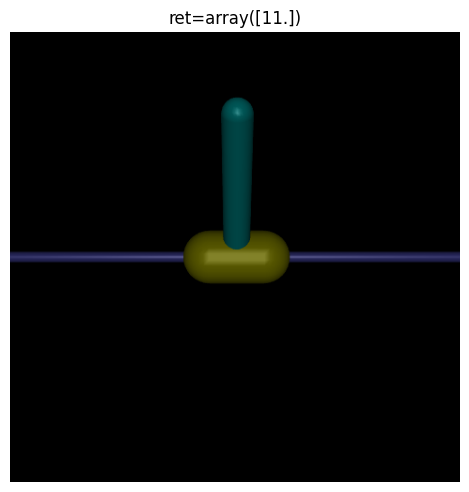

KeyboardInterrupt: 

In [5]:
# Load trained parameters
theta = np.load('trained_theta.npy')
obs, info = env.reset()
terminated = [False]
ret = 0
while not all(terminated):
    state=obs[0]
    action = np.clip(np.dot(theta,state), env.action_space.low, env.action_space.high)  # Get action from the trained policy
    obs, reward, terminated, truncated, info = env.step(action)
    terminated = terminated | truncated
    ret += reward
    render_notebook(env, 0, f"{ret=}")